In [36]:
import torch
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
from torchvision.models import resnet34
from PIL import Image
import numpy as np

In [37]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Running on {device}")

Running on cuda:0


In [38]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [39]:
class PokemonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        for cls_name in self.classes:
            for file_name in os.listdir(os.path.join(root_dir, cls_name)):
                self.samples.append((os.path.join(root_dir, cls_name, file_name), cls_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        image = torch.from_numpy(np.array(image)).float()
        target = self.class_to_idx[target]
        return {'image': image}, target


In [40]:
dataset = PokemonDataset(root_dir='PokemonData', transform=transform)
lengths = [int(0.7 * len(dataset)), int(0.15 * len(dataset)), len(dataset) - int(0.7 * len(dataset)) - int(0.15 * len(dataset))]
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)

In [41]:
item = dataset[0]


In [42]:
item [0]

{'image': tensor([[[2.2147, 2.1975, 2.2147,  ..., 2.2318, 2.2318, 2.1975],
          [2.1804, 2.2147, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2147, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2318, 2.2489, 2.2489,  ..., 2.1804, 2.1804, 2.1975],
          [2.2318, 2.2318, 2.2318,  ..., 2.1975, 2.1975, 2.1975],
          [2.2318, 2.2318, 2.2318,  ..., 2.2147, 2.1975, 2.1804]],
 
         [[1.3256, 1.4657, 1.6583,  ..., 0.6078, 0.5203, 0.4503],
          [1.2556, 1.4482, 1.6408,  ..., 0.6078, 0.5728, 0.5203],
          [1.2381, 1.4132, 1.6057,  ..., 0.6078, 0.5728, 0.5203],
          ...,
          [0.3452, 0.4328, 0.5203,  ..., 0.9055, 0.9230, 0.9055],
          [0.3452, 0.4153, 0.5203,  ..., 0.9055, 0.9055, 0.8880],
          [0.3452, 0.4153, 0.5028,  ..., 0.8704, 0.8880, 0.8704]],
 
         [[2.0125, 2.1346, 2.2914,  ..., 1.5768, 1.4548, 1.3502],
          [1.9428, 2.0997, 2.2740,  ..., 1.5942, 1.5245, 1.4200],
          [1.9428, 2.0997, 2.23

In [43]:
item[1]

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


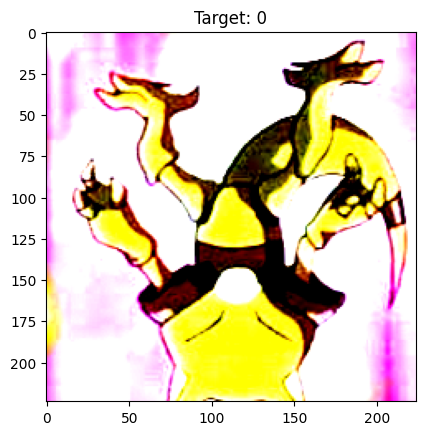

In [44]:


image_np = item[0]["image"].numpy()

# Reshape the numpy array to the original shape of the image
image_np = np.transpose(image_np, (1, 2, 0))

# Display the image using matplotlib
plt.imshow(image_np)
plt.title(f'Target: {item[1]}')
plt.show()

In [45]:
len(train_dataset)

4775

In [46]:
len(val_dataset)

1023

In [47]:
len(test_dataset)

1024

In [48]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [49]:
model = resnet34(num_classes=150)
device = torch.device(device)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [53]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data_dict, target) in enumerate(train_loader):
        data = data_dict['image'].to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data["image"].to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / len(val_loader.dataset)
    return val_loss, accuracy


In [54]:
num_epochs = 1
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    val_loss, val_acc = validate(model, device, val_loader)
    print('Epoch: {:03d}, Val Loss: {:.3f}, Val Acc: {:.3f}'.format(epoch + 1, val_loss, val_acc))


Epoch: 001, Val Loss: 0.137, Val Acc: 6.549%
